In [1]:
# Example modeling a PFR using an adaptively sized chain of CSTRs

In [32]:
import cantera as ct
import numpy as np
import signal
import os
import copy
import scipy.interpolate
import logging

import pandas as pd

import matplotlib.pyplot as plt

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [33]:
# constants/objects to set up once at the beginning and then reuse for each simulation
# these are the same for all simulations and do not need to be reloaded each time
N_REACTORS = 1001  # used for sizing the minimum reactor size
MIN_SIM_DIST = -0.001  # in meters
MAX_SIM_DIST = 0.0125  # in meters
TOTAL_PFR_LEN = MAX_SIM_DIST - MIN_SIM_DIST
BASE_INDIVIDUAL_CSTR_LEN = TOTAL_PFR_LEN / N_REACTORS
# dist_array = np.linspace(MIN_SIM_DIST, MAX_SIM_DIST, N_REACTORS)

In [34]:
UNCERTAINTY_REPO = os.environ['UNCERTAINTY_REPO']
# set up the temperature profile as a function of distance along the reactor
# pt_data = os.path.join(os.path.dirname(__file__), '../../cpox_pt/horn_data/pt_profiles_smooth.csv')
pt_data = os.path.join(UNCERTAINTY_REPO, './cpox_pt/horn_data/pt_profiles_smooth.csv')
df = pd.read_csv(pt_data)
distances = (df['Distance (mm)'] - 10.0) / 1000.0  # ignore the 10mm of no/catalyst space
exp_Ts = df['Temperature (K)']
temperature_function = scipy.interpolate.interp1d(distances, exp_Ts, fill_value='extrapolate')

use_temperature_profile = True

In [35]:
# ----------------------- Parameters specific to Horn CPOX experiment -----------------------
REACTOR_DIAMETER = 0.0165
CROSS_SECTION_AREA = (REACTOR_DIAMETER / 2.0) ** 2.0 * np.pi
POROSITY = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
CAT_AREA_PER_VOL = 16000  # made-up
FLOW_RATE_SLPM = 4.7  # slpm
FLOW_RATE = FLOW_RATE_SLPM * 0.001 / 60  # m^3/s
velocity = FLOW_RATE / CROSS_SECTION_AREA  # m/s
residence_time = BASE_INDIVIDUAL_CSTR_LEN / velocity # unit in s
individual_cstr_vol = CROSS_SECTION_AREA * BASE_INDIVIDUAL_CSTR_LEN * POROSITY
individual_cstr_cat_area = CAT_AREA_PER_VOL * individual_cstr_vol
if use_temperature_profile:
    T_INLET = temperature_function(MIN_SIM_DIST)
else:
    T_INLET = 700.0  # K  -- won't matter if using the temperature profile
x_CH4 = 0.296  # inlet mole fraction of methane
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2
P_INLET = ct.one_atm  # Pa

In [36]:
# Plotting settings
FIG_HEIGHT = 6.0
FIG_WIDTH = 12.0

In [58]:
def get_i_thing(ref_composition, phase):
    """Helper function for getting the index of a species in a Cantera phase given its composition"""
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False, f"Could not find species with composition {ref_composition} in phase {phase.name}"

In [59]:
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/cantera/chem_annotated_mod.yaml'
gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])

In [60]:
surf_thermo_perturb = {}
if surf_thermo_perturb:
    for index in surf_thermo_perturb.keys():
        increase_enthalpy(surf, index, surf_thermo_perturb[index])
        logging.debug(f"Increased enthalpy of surface species {surf.species_names[index]} by {surf_thermo_perturb[index]} J/mol")

# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)

In [61]:
# Initialize the reactor
X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = FLOW_RATE * gas.density_mass
gas.TPX = T_INLET, P_INLET, X
surf.TP = T_INLET, P_INLET

initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_X] = 1.0
surf.coverages = initial_coverages


In [62]:
# create a new reactor
if use_temperature_profile:
    r = ct.IdealGasReactor(gas, energy='off')
else:
    r = ct.IdealGasReactor(gas, energy='on')
r.volume = individual_cstr_vol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
if ct.__version__ in ['2.6.0']:
    v = ct.PressureController(r, downstream, master=m, K=1e-5)
else:
    v = ct.PressureController(r, downstream, primary=m, K=1e-5)

/tmp/ipykernel_3130/3305946539.py:3: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasReactor(gas, energy='off')
/tmp/ipykernel_3130/3305946539.py:7: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  upstream = ct.Reservoir(gas, name='upstream')
/tmp/ipykernel_3130/3305946539.py:8: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. A

In [63]:
sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

In [64]:
# kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
# gas_out = [1000 * 60 * kmole_flow_rate * gas.X.copy()]
# surf_out = [surf.X.copy()]
# gas_rates = [gas.net_rates_of_progress]
# surf_rates = [surf.net_rates_of_progress]
# T_array = [surf.T]
# dist_array = [MIN_SIM_DIST]  # gives the starting distance of each CSTR
# cstr_len_array = [BASE_INDIVIDUAL_CSTR_LEN]  # gives the length of each CSTR

kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
gas_out = []
surf_out = []
gas_rates = []
surf_rates = []
T_array = []
dist_array = []  # gives the ending distance of each CSTR
cstr_len_array = []  # gives the length of each CSTR


surf_kinetics_perturb = {}



# start in the non-catalyst region
surf.set_multiplier(0.0)

n = 0  # CSTR index
sim_dist = MIN_SIM_DIST
while sim_dist < MAX_SIM_DIST:
    
    # Set the state of the reservoir to match that of the previous reactor
    if use_temperature_profile:
        gas.TDY = temperature_function(sim_dist), r.thermo.DP[0], r.thermo.Y
        # surf.TD = temperature_function(sim_dist), surf.TD[1]
        r.syncState()
        upstream.syncState()
    else:
        gas.TDY = r.thermo.TDY
        upstream.syncState()

    # Adapt the reactor length
    # ----------------------- Parameters specific to Horn CPOX experiment -----------------------
    # individual_cstr_len = BASE_INDIVIDUAL_CSTR_LEN

    
    if sim_dist < 0.005:
        individual_cstr_len = BASE_INDIVIDUAL_CSTR_LEN
    else:
        individual_cstr_len = 10.0 * BASE_INDIVIDUAL_CSTR_LEN
    residence_time = individual_cstr_len / velocity # unit in s
    individual_cstr_vol = CROSS_SECTION_AREA * individual_cstr_len * POROSITY
    individual_cstr_cat_area = CAT_AREA_PER_VOL * individual_cstr_vol
    r.volume = individual_cstr_vol
    rsurf.area = individual_cstr_cat_area
    
    sim.reinitialize()
    if n > 1 and dist_array[n - 1] >= 0 and dist_array[n - 2] < 0:
        # turn the surface reactions on as we enter the catalyst region
        surf.set_multiplier(1.0)

        # apply kinetic perturbations to the surface reactions
        if surf_kinetics_perturb:
            for index in surf_kinetics_perturb.keys():
                surf.set_multiplier(surf_kinetics_perturb[index], index)
                logging.debug(f"Set multiplier of surface reaction {surf.reactions()[index].equation} to {surf_kinetics_perturb[index]}")

    elif sim_dist >= 0.01:
        # turn the surface reactions off as we exit the catalyst region
        surf.set_multiplier(0.0)


    sim.initial_time = 0.0
    sim.advance(sim.time + 1e4 * residence_time)
    # add timeout handling here if the simulation takes too long

    
    kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
    gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
    surf_out.append(surf.X.copy())
    gas_rates.append(gas.net_rates_of_progress)
    surf_rates.append(surf.net_rates_of_progress)
    T_array.append(surf.T)

    sim_dist += individual_cstr_len
    dist_array.append(sim_dist)
    cstr_len_array.append(individual_cstr_len)
    n += 1
    


/tmp/ipykernel_3130/155888692.py:33: DeprecationWarning: ReactorBase.thermo: To be removed after Cantera 3.2. Renamed to `phase`.
  gas.TDY = temperature_function(sim_dist), r.thermo.DP[0], r.thermo.Y


In [65]:
gas_out = np.array(gas_out)
surf_out = np.array(surf_out)
gas_rates = np.array(gas_rates)
surf_rates = np.array(surf_rates)
T_array = np.array(T_array)

dist_array = np.array(dist_array)

(-0.001, 0.0125)

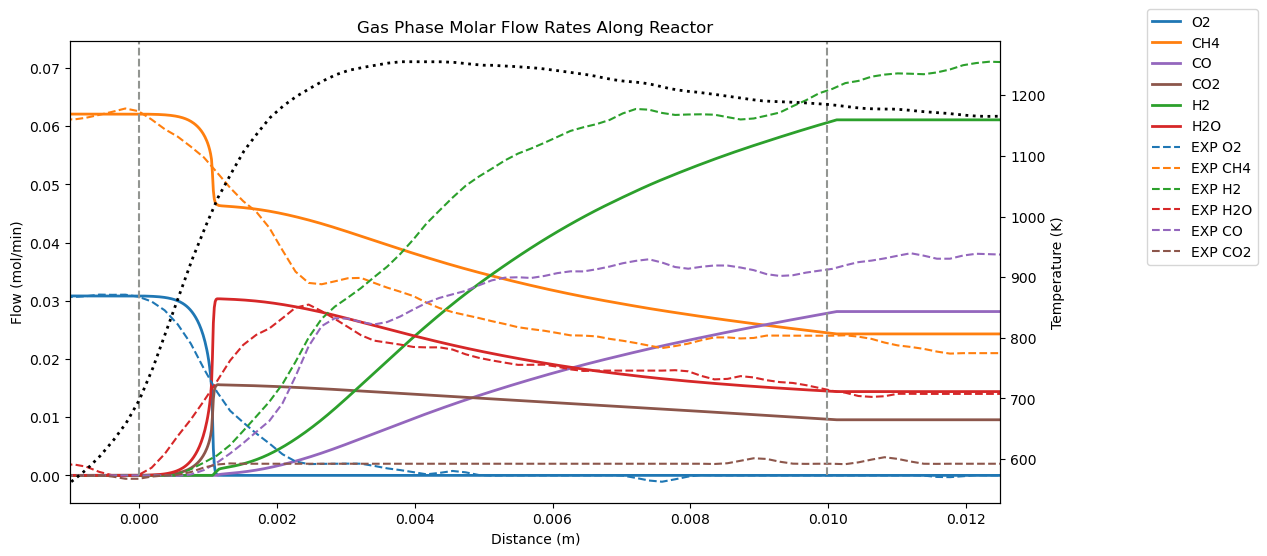

In [66]:
# Get indices of key species
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)

# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(FIG_HEIGHT)
fig.set_figwidth(FIG_WIDTH)

# Simulation Results
plt.plot(dist_array, gas_out[:, i_O2], label='O2', color=colors[0], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CH4], label='CH4', color=colors[1], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO], label='CO', color=colors[4], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO2], label='CO2', color=colors[5], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2], label='H2', color=colors[2], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2O], label='H2O', color=colors[3], linewidth=linewidth2)

# Experimental data
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['O2 (mol/min)'].values, linestyle='dashed', label='EXP O2', color=colors[0])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['CH4 (mol/min)'].values, linestyle='dashed', label='EXP CH4', color=colors[1])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['H2 (mol/min)'].values, linestyle='dashed', label='EXP H2', color=colors[2])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['H2O (mol/min)'].values, linestyle='dashed', label='EXP H2O', color=colors[3])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['CO (mol/min)'].values, linestyle='dashed', label='EXP CO', color=colors[4])
plt.plot((df['Distance (mm)'].values - 10.0) / 1000.0, df['CO2 (mol/min)'].values, linestyle='dashed', label='EXP CO2', color=colors[5])

ax1 = plt.gca()
ylim = ax1.get_ylim()
# Mark the catalyst extent
CAT_ON_INDEX = np.argmin(np.abs(dist_array - 0))
CAT_OFF_INDEX = np.argmin(np.abs(dist_array - 0.01))
plt.plot([dist_array[CAT_ON_INDEX], dist_array[CAT_ON_INDEX]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.plot([dist_array[CAT_OFF_INDEX], dist_array[CAT_OFF_INDEX]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.ylim(ylim)
plt.title('Gas Phase Molar Flow Rates Along Reactor')

ax2 = ax1.twinx()
if T_array is not None:
    ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
    ax2.set_ylabel('Temperature (K)')
    ax2.yaxis.get_major_formatter().set_useOffset(False)
else:
    ax2.plot(dist_array, temperature_profile, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
    
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
ax1.set_ylim(np.float64(-0.004696180909457905), np.float64(0.07467074545684121))
ax1.set_xlim(MIN_SIM_DIST, MAX_SIM_DIST)


In [67]:
len(dist_array)

501